In [8]:
import numpyro
import numpyro.distributions as dist
from numpyro.handlers import seed, trace
import jax
import jax.numpy as jnp
from jax import random
from jax.scipy.integrate import trapezoid
import numpy as np

from sim_utils import *
from clip import *
import matplotlib.pylab as plt

In [2]:

def sample(nworms):
    with numpyro.plate('nworms', nworms):
        # L = numpyro.sample('L', dist.Uniform(30, 45))
        L = numpyro.sample('L', dist.Uniform(10, 15))
        A = numpyro.sample('A', dist.Normal(1, 0.1))
        T = numpyro.sample('T', dist.Normal(0.8, 0.1))
        kw = numpyro.sample('kw', dist.Uniform(0, 2 * jnp.pi))
        ku = numpyro.sample('ku', dist.Normal(jnp.pi, 1))
        
        inc = numpyro.sample('inc', dist.Uniform(0, 2 * jnp.pi))
        dr = numpyro.sample('dr', dist.Uniform(0.2, 0.8))
        phase_1 = numpyro.sample('phase_1', dist.Uniform(0, 2 * jnp.pi))
        phase_2 = numpyro.sample('phase_2', dist.Uniform(0, 2 * jnp.pi))
        phase_3 = numpyro.sample('phase_3', dist.Normal(0, 0.1))
        alpha = numpyro.sample('alpha', dist.Normal(4, 4))

        alpha = jnp.abs(alpha + 1.0)
        half_box = box_size // 2
        x0 = numpyro.sample('x0', dist.Uniform(-half_box, half_box))
        y0 = numpyro.sample('y0', dist.Uniform(-half_box, half_box))

        params = {'L': L, 'A': A, 'T': T, 'kw': kw, 'ku': ku, 'inc': inc, 'dr': dr, 'phase_1': phase_1, 'phase_2': phase_2, 'phase_3': phase_3, 'alpha': alpha, 'x0': x0, 'y0': y0}
        duration = 0.55
        snapshots = 10
        kpoints = 6

        sim_fn = partial(
            worm_simulation,
            duration=duration,
            snapshots=snapshots,
            kpoints=kpoints,
        )
        worm = jax.vmap(sim_fn, out_axes=1)(params)
        worm = worm + box_size // 2
        numpyro.deterministic('worm', worm)


In [5]:
# seed and trace
key, nworms, box_size = random.PRNGKey(0), 2, 64

seeded_model = seed(sample, key)
trs = []
for i in range(12):
    tr = trace(seeded_model).get_trace(nworms)
    trs.append(tr)

In [4]:
tr['worm']['value']

Array([[[[14.014416 , 37.77558  ],
         [13.685234 , 39.897324 ],
         [12.446371 , 41.650993 ],
         [10.312077 , 41.885372 ],
         [ 8.2374935, 41.33197  ],
         [ 6.2057533, 42.026363 ]],

        [[43.033928 , 58.29866  ],
         [41.514317 , 59.465607 ],
         [39.905575 , 60.506233 ],
         [39.11317  , 62.25067  ],
         [39.609703 , 64.1012   ],
         [40.348877 , 65.86884  ]]],


       [[[12.940207 , 38.907017 ],
         [13.750624 , 40.895325 ],
         [12.334057 , 42.508858 ],
         [10.390612 , 41.596077 ],
         [ 8.64884  , 40.340534 ],
         [ 6.778595 , 41.39521  ]],

        [[43.16144  , 58.227562 ],
         [41.6985   , 59.464806 ],
         [40.03902  , 60.422455 ],
         [39.261078 , 62.17339  ],
         [39.54255  , 64.06858  ],
         [39.541687 , 65.98456  ]]],


       [[[13.133179 , 39.874645 ],
         [13.881973 , 41.88697  ],
         [11.905695 , 42.726303 ],
         [10.488333 , 41.11347  ],
        

In [6]:
# clip = convert_to_clip(tr['worm']['value'], box_size)
clips = [convert_to_clip(tr['worm']['value'], box_size) for tr in trs]

In [11]:
# save as npy
np.save('worms_train.npy', np.stack(clips))

In [27]:
tr['worm']['value'].shape

(10, 4, 6, 2)

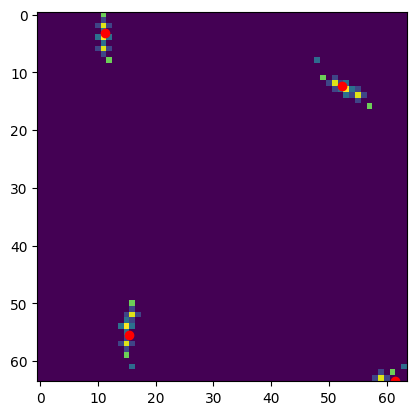

In [40]:
i = 9
plt.imshow(clip[i])
# plot points at means
# plt.scatter(tr['x0']['value'], tr['y0']['value'])
plt.scatter(tr['worm']['value'].mean(axis=-2)[i, ..., 0], tr['worm']['value'].mean(axis=-2)[i, ..., 1], c='r')
# plt.scatter(tr['worm']['value'].mean(axis=-2)[0, ..., 0], tr['worm']['value'].mean(axis=-2)[0, ..., 1], c='r')